In [2]:
import os

from collections import OrderedDict

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import scipy

import warnings

from Standard_functions import plot_features, get_user_split_data, plot_fit_score_pred

warnings.filterwarnings('always') 
np.seterr(divide='ignore', invalid='ignore')
%matplotlib inline

In [3]:
os.chdir('../Data/')

In [4]:
os.listdir()

['mini_feature_df',
 'mini_df',
 'products.csv',
 'orders.csv',
 '.DS_Store',
 '00_merged_prod_order',
 'mini_ord_prod_train_df',
 'order_products__train.csv',
 'departments.csv',
 'aisles.csv',
 'mini_ord_df',
 'order_products__prior.csv',
 'sample_submission.csv']

## Loading our Datasets

In [5]:
df = pd.read_pickle('00_merged_prod_order')
ord_prod_train_df = pd.read_csv('order_products__prior.csv')
ord_prod_test_df = pd.read_csv('order_products__train.csv')
ord_df = pd.read_csv('orders.csv')
ord_prod_train_df = ord_prod_train_df.merge(ord_df, on='order_id')
ord_prod_test_df = ord_prod_test_df.merge(ord_df, on='order_id')

#### Making mini and pickling

``` python
rs = np.random.RandomState(101)

total_users = df['user_id'].unique()
small_df_users = rs.choice(total_users, 
               size=int(total_users.shape[0] * .005), 
               replace=False)

df = df[df['user_id'].isin(small_df_users)]
ord_prod_train_df = ord_prod_train_df[ord_prod_train_df.user_id.isin(small_df_users)]
ord_df = ord_df[ord_df.user_id.isin(small_df_users)]
pd.to_pickle(df,'mini_df')
pd.to_pickle(ord_prod_train_df,'mini_ord_prod_train_df')
pd.to_pickle(ord_df,'mini_ord_df')
```

df = pd.read_pickle('mini_df')
ord_prod_train_df = pd.read_pickle('mini_ord_prod_train_df')
ord_df = pd.read_pickle('mini_ord_df')

In [6]:
df.user_id.nunique()

131209

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8474661 entries, 0 to 8474660
Data columns (total 5 columns):
product_id                   int64
user_id                      int64
num_ord_per_user_per_prod    int64
latest_cart                  object
in_cart                      int64
dtypes: int64(4), object(1)
memory usage: 387.9+ MB


## Feature Engineering

Our feature engineering began in the 'Organizing data section.  
We will visualize that first feature below and begin creating new features.

<Figure size 648x648 with 0 Axes>

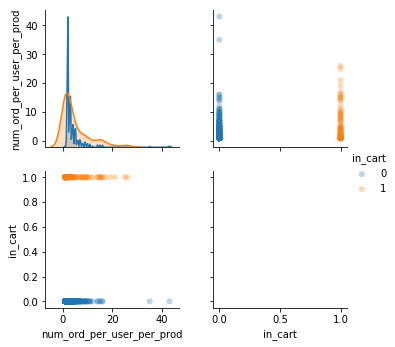

Our f1-score is 0.0864409013045197
The coefficients are: 
                     Features  Coefficients
0  num_ord_per_user_per_prod        0.1422
And we've predicted 1675585 non-re-orders and 16723 re-orders.


In [8]:
X_tr, X_val, y_tr, y_val = get_user_split_data(df)
plot_fit_score_pred(df, X_tr, X_val, y_tr, y_val)

As you can see, we're setting the bar pretty low.

## Product Features
Note that product features are not user-specific.

### `product_total_orders`
Total number of orders placed for a given product.
### `product_avg_add_to_cart_order`
Average order in which a product was add to a users cart.

In [9]:
prod_features = ['product_total_orders','product_avg_add_to_cart_order']

df_prod_features = (ord_prod_train_df.groupby(['product_id'],as_index=False)
                                           .agg(OrderedDict(
                                                   [('order_id','nunique'),
                                                    ('add_to_cart_order','mean')])))
df_prod_features.columns = ['product_id'] + prod_features
df = df.merge(df_prod_features, on='product_id')

`product_total_orders` had some pretty enourmous rightward skew that ultimately resulted in the model producing 0 positive predictions. As a result I took the log base 2 transformation to punish outliers.  
Note that I attempted a log base 10 transformation but log base 2 had better results.

In [10]:
df.product_total_orders = np.log2(df.product_total_orders)

<Figure size 648x648 with 0 Axes>

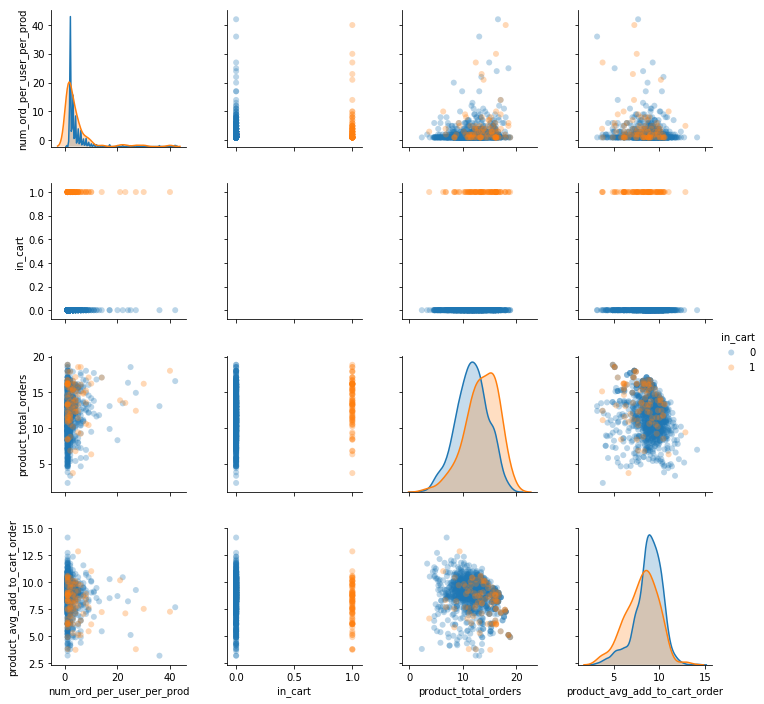

Our f1-score is 0.08767651253688119
The coefficients are: 
                         Features  Coefficients
0      num_ord_per_user_per_prod        0.1230
1           product_total_orders        0.0795
2  product_avg_add_to_cart_order       -0.1667
And we've predicted 1679289 non-re-orders and 16445 re-orders.


In [11]:
X_tr, X_val, y_tr, y_val = get_user_split_data(df)
plot_fit_score_pred(df, X_tr, X_val, y_tr, y_val)

## User Features
`'user_total_orders','user_avg_cartsize','user_total_products','user_avg_days_since_prior_order'`

In [12]:
user_features = ['user_total_orders','user_avg_cartsize',
                 'user_total_products','user_avg_days_since_prior_order']

df_user_features = (ord_prod_train_df.groupby(['user_id'],as_index=False)
                    .agg(OrderedDict(
                       [('order_id',
                         ['nunique', # user_total_orders
                        (lambda x: x.shape[0] / x.nunique())]), # user_avg_cartsize
                        ('product_id','nunique'), # user_total_products
                        ('days_since_prior_order','mean')]))) # user_avg_days_since_prior_order
df_user_features.columns = ['user_id'] + user_features
df = df.merge(df_user_features, on='user_id')

<Figure size 648x648 with 0 Axes>

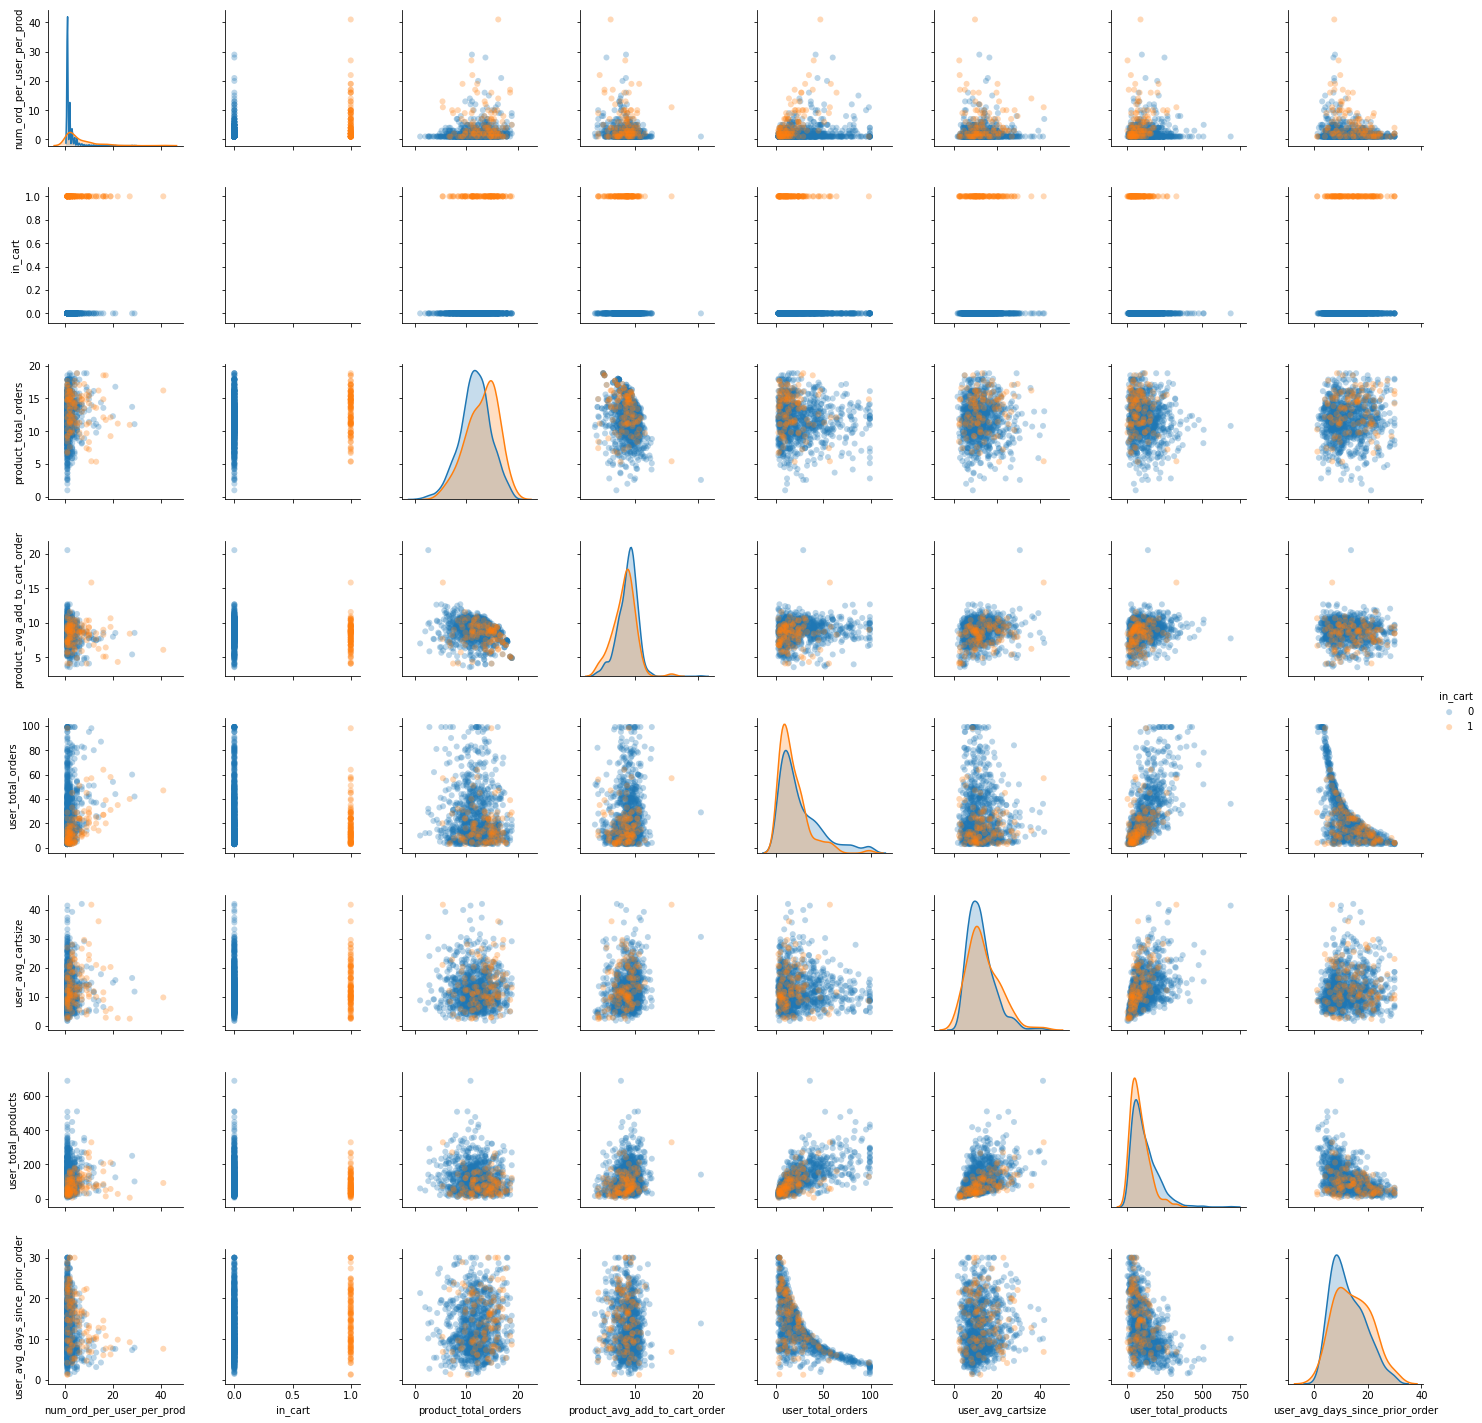

Our f1-score is 0.12110314302130103
The coefficients are: 
                           Features  Coefficients
0        num_ord_per_user_per_prod        0.1809
1             product_total_orders        0.0726
2    product_avg_add_to_cart_order       -0.1338
3                user_total_orders       -0.0231
4                user_avg_cartsize        0.0447
5              user_total_products       -0.0054
6  user_avg_days_since_prior_order       -0.0016
And we've predicted 1675015 non-re-orders and 20719 re-orders.


In [13]:
X_tr, X_val, y_tr, y_val = get_user_split_data(df)
plot_fit_score_pred(df, X_tr, X_val, y_tr, y_val)

## User-Product features

In [14]:
user_prod_features = ['user_product_avg_add_to_cart_order']

df_user_prod_features = (ord_prod_train_df.groupby(
                        ['product_id','user_id'],as_index=False) \
                        .agg(OrderedDict(
                        [('add_to_cart_order','mean')])))

df_user_prod_features.columns = ['product_id','user_id'] + user_prod_features 
df = df.merge(df_user_prod_features,on=['user_id','product_id'])
df['user_product_order_freq'] = df['num_ord_per_user_per_prod'] / df['user_total_orders'] 

<Figure size 648x648 with 0 Axes>

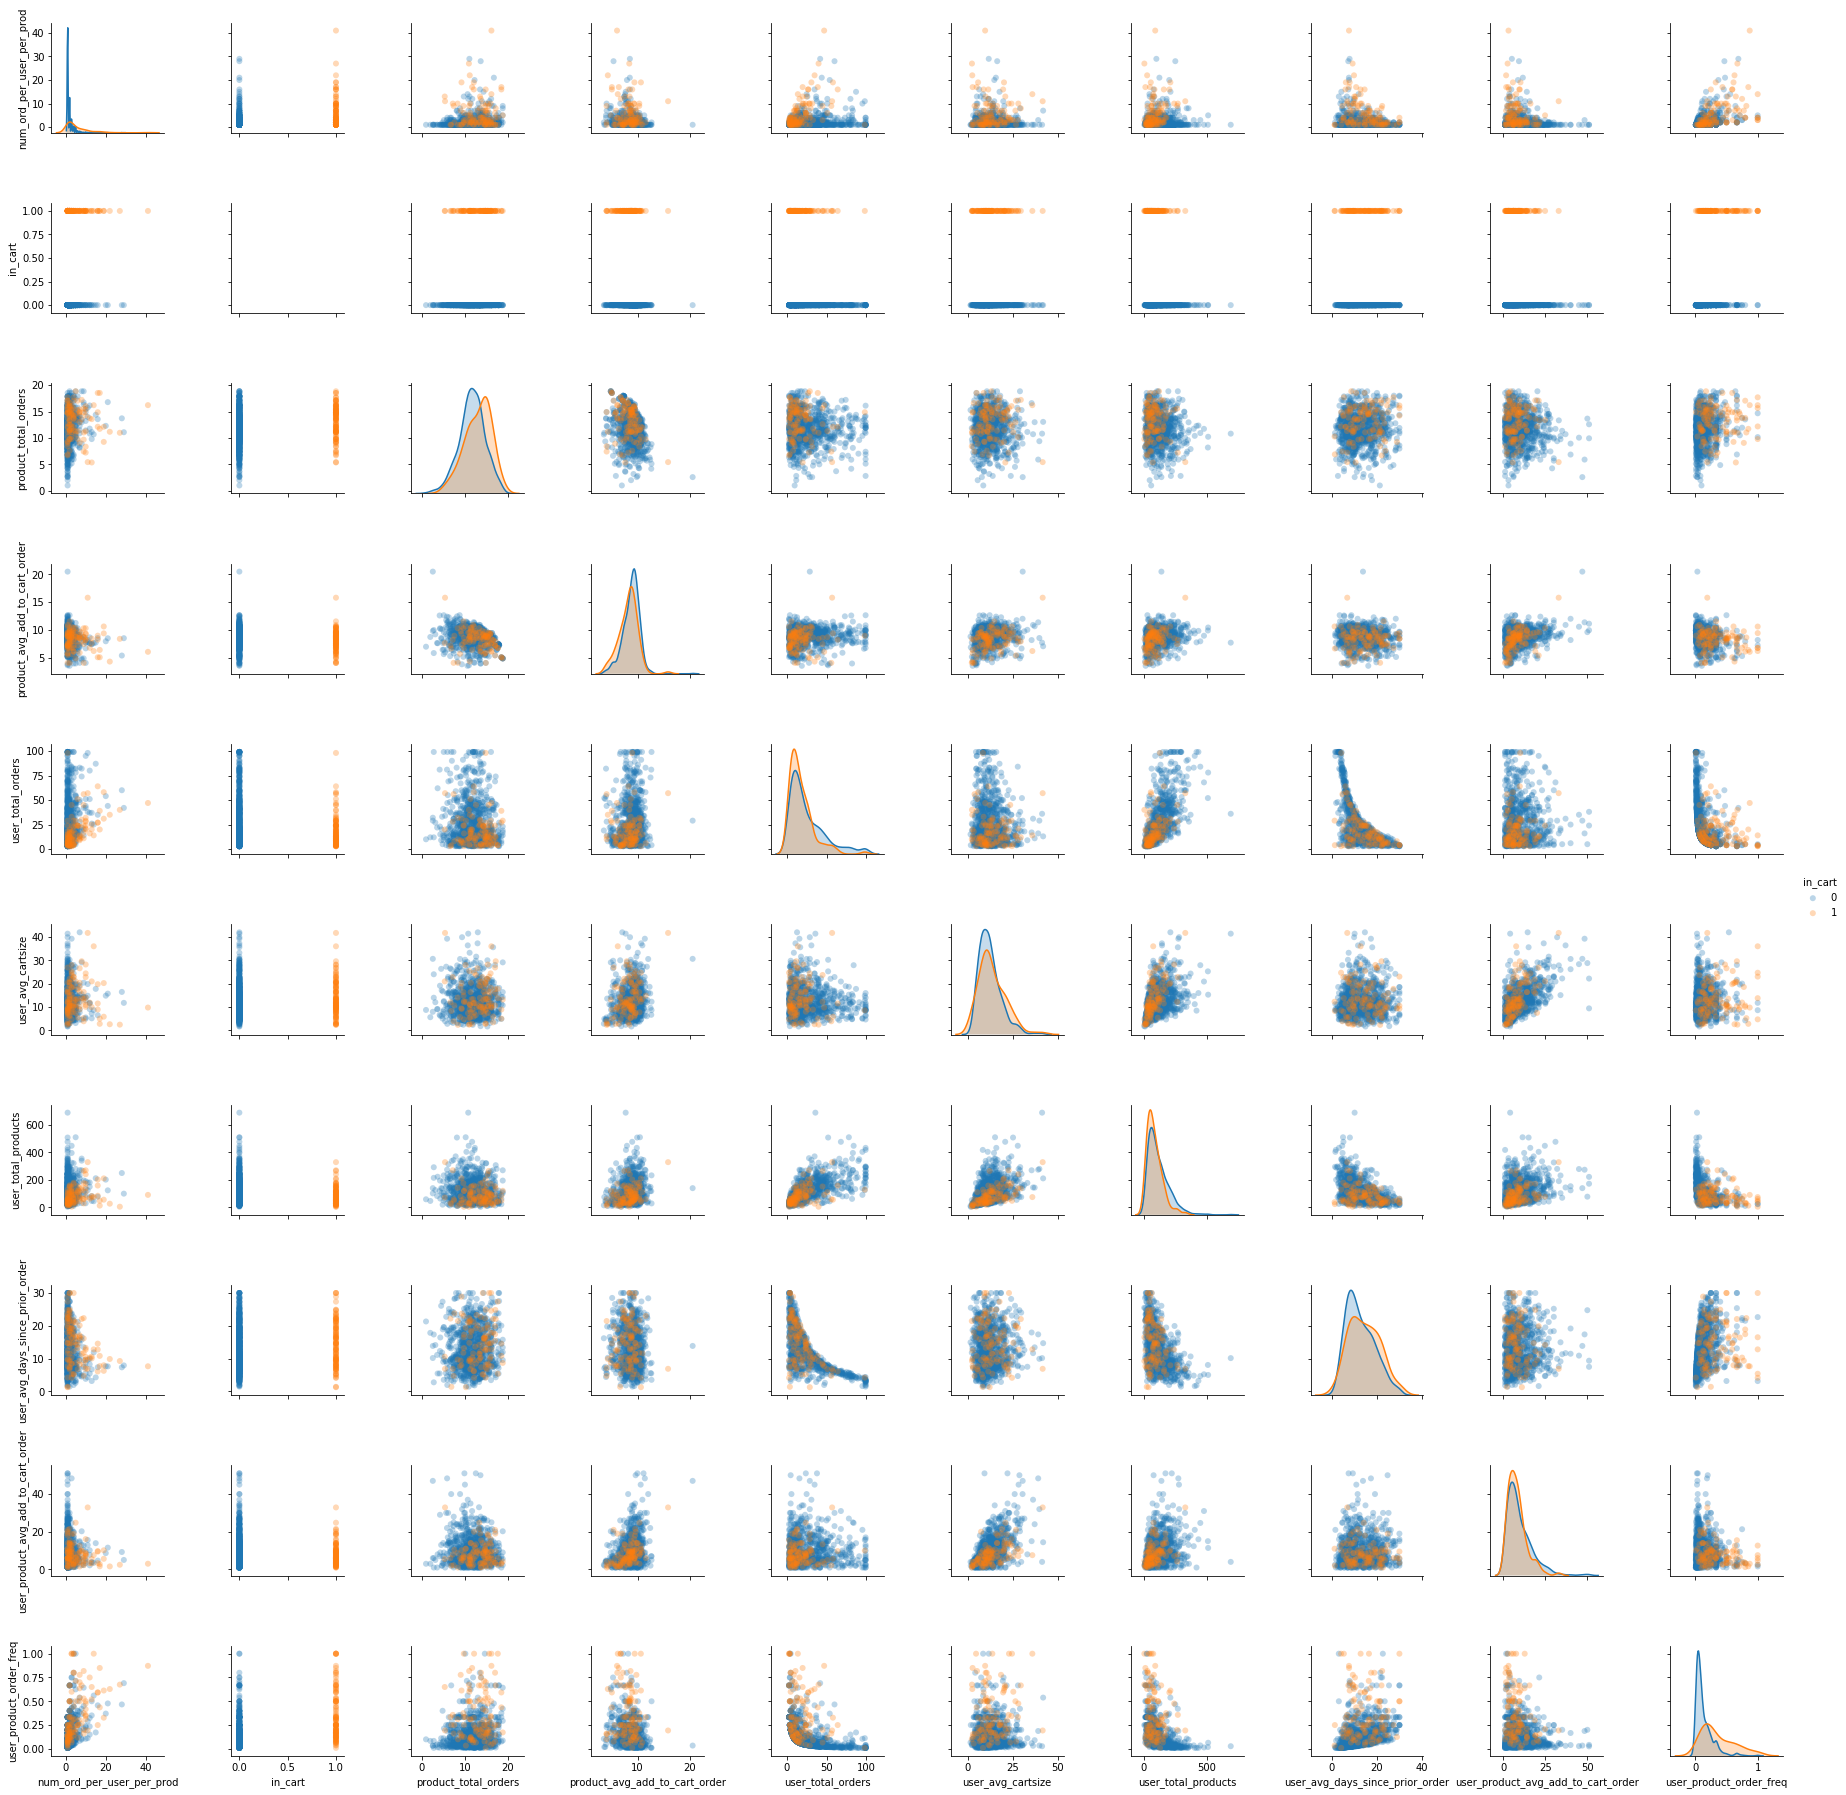

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Our f1-score is 0.22880326889347186
The coefficients are: 
                              Features  Coefficients
0           num_ord_per_user_per_prod        0.0601
1                product_total_orders        0.0339
2       product_avg_add_to_cart_order       -0.1371
3                   user_total_orders       -0.0081
4                   user_avg_cartsize        0.0142
5                 user_total_products       -0.0016
6     user_avg_days_since_prior_order       -0.0180
7  user_product_avg_add_to_cart_order        0.0015
8             user_product_order_freq        3.6194
And we've predicted 1655455 non-re-orders and 40279 re-orders.


In [15]:
X_tr, X_val, y_tr, y_val = get_user_split_data(df)
plot_fit_score_pred(df, X_tr, X_val, y_tr, y_val)

## Users Orders Features
mean, min, and max of order hour of day by user all proved to be poor predictors.

In [16]:
orders_features = ['mean_order_hour_of_day_by_user','min_order_hour_of_day_by_user',
                 'max_order_hour_of_day_by_user']

df_orders_features = (ord_df.groupby(['user_id'],as_index=False)
                    .agg(OrderedDict(
                       [('order_hour_of_day',
                         ['mean', 'min', 'max'])]))) # user_avg_days_since_prior_order
df_orders_features.columns = ['user_id'] + orders_features
df = df.merge(df_orders_features, on='user_id')

Further grouping of the above by product provided no additional insight.

In [17]:
avg_order_hour_by_user_by_product = (ord_prod_train_df
                             .dropna().groupby(['user_id','product_id']
                                ,as_index=False).order_hour_of_day.mean())

avg_order_hour_by_user_by_product.columns = ['user_id','product_id','avg_order_hour_by_user_by_product'] 
df = pd.merge(df, avg_order_hour_by_user_by_product,on=['user_id','product_id'])

## Count of Orders by Day of Week

In [18]:
dummies = pd.get_dummies(ord_df.order_dow)
df_dummies = pd.merge(ord_df,dummies,how='outer',left_index=True,right_index=True)
total_orders_by_dow = (df_dummies.groupby('user_id',as_index=False)
                  .sum().drop(['order_number','order_dow','order_hour_of_day',
                              'days_since_prior_order'],axis=1))
total_orders_by_dow.columns = (['user_id','order_id'] + 
                    ['total_orders_day ' + str(x) for x in range(0,7)])
df = pd.merge(df, total_orders_by_dow,on=['user_id'])

## Mode Hour and DOW Ordered

In [19]:
product_mode_hour_ordered = (ord_prod_train_df.groupby('product_id',
                              as_index=False).order_hour_of_day
                             .agg(lambda x:x.value_counts().index[0]))
product_mode_hour_ordered.columns = ['product_id','product_mode_hour_ordered']
df = pd.merge(df, product_mode_hour_ordered,on=['product_id'])

In [20]:
product_mode_dow_ordered = (ord_prod_train_df.groupby('product_id',
                              as_index=False).order_dow
                             .agg(lambda x:x.value_counts().index[0]))
product_mode_dow_ordered.columns = ['product_id','product_mode_dow_ordered']
df = pd.merge(df, product_mode_dow_ordered,on=['product_id'])

<Figure size 648x648 with 0 Axes>

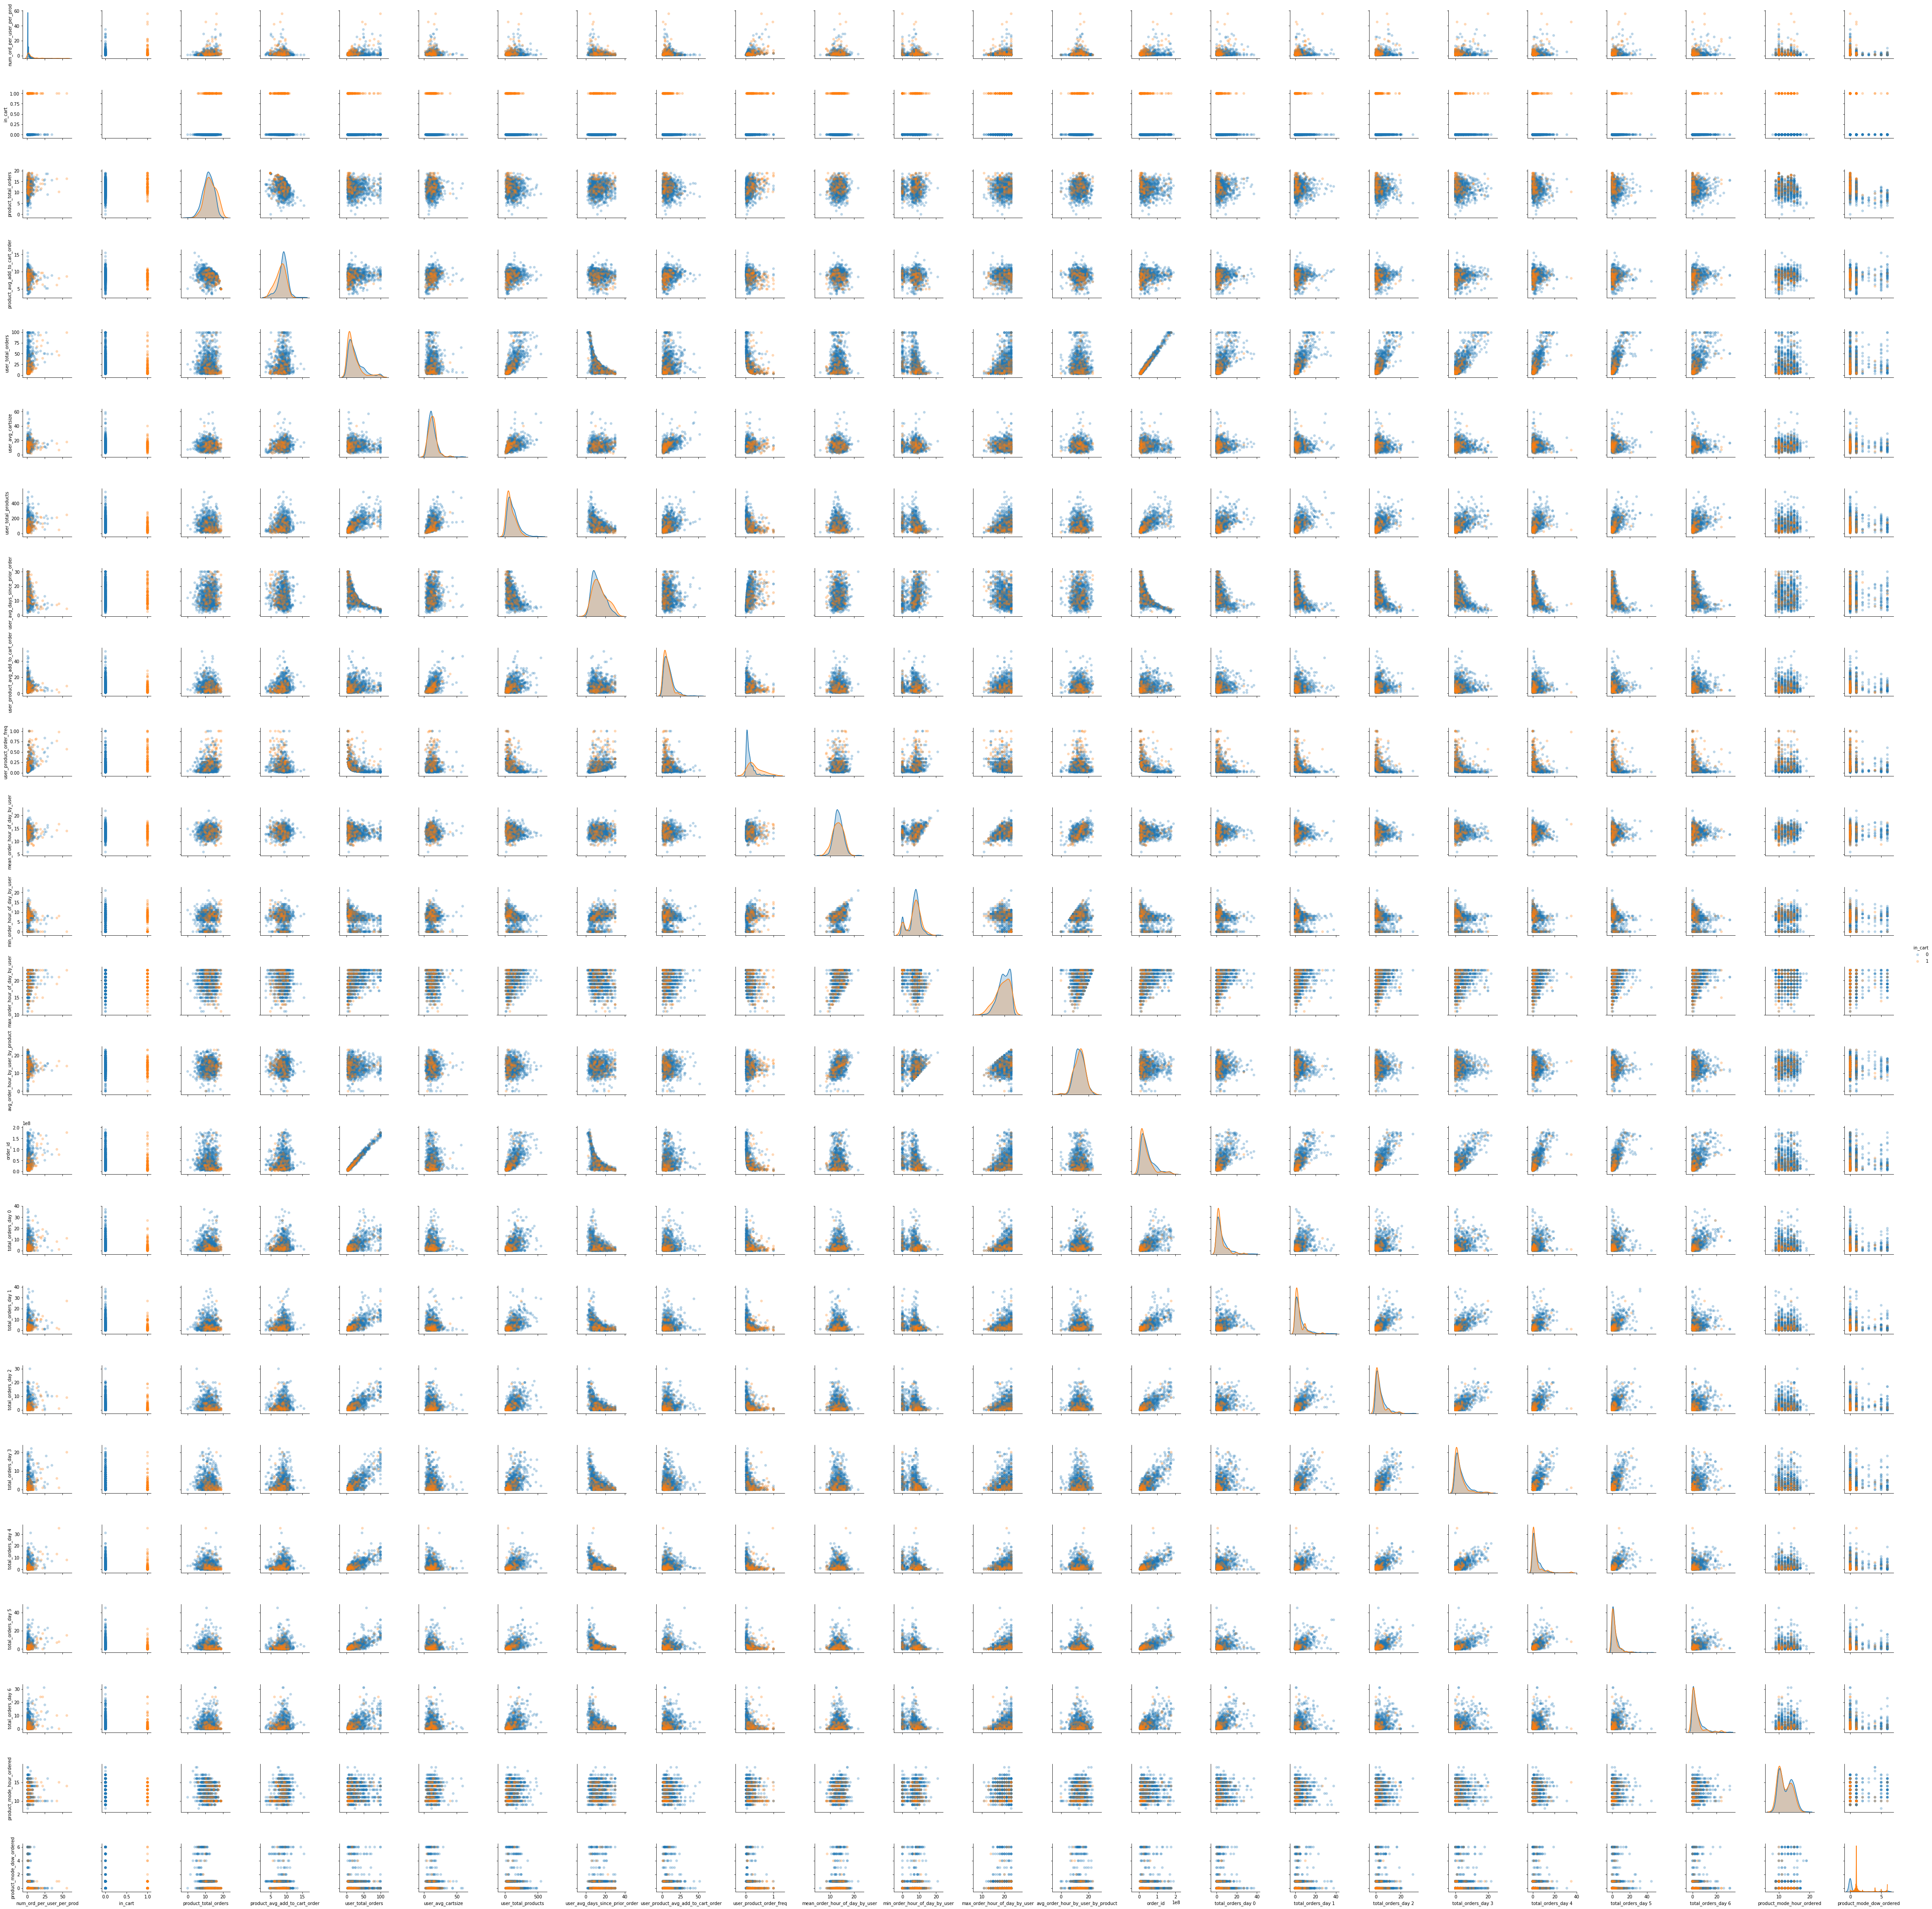

Our f1-score is 0.0
The coefficients are: 
                               Features  Coefficients
0            num_ord_per_user_per_prod           0.0
1                 product_total_orders          -0.0
2        product_avg_add_to_cart_order          -0.0
3                    user_total_orders          -0.0
4                    user_avg_cartsize          -0.0
5                  user_total_products          -0.0
6      user_avg_days_since_prior_order          -0.0
7   user_product_avg_add_to_cart_order          -0.0
8              user_product_order_freq           0.0
9       mean_order_hour_of_day_by_user          -0.0
10       min_order_hour_of_day_by_user          -0.0
11       max_order_hour_of_day_by_user          -0.0
12   avg_order_hour_by_user_by_product          -0.0
13                            order_id          -0.0
14                  total_orders_day 0          -0.0
15                  total_orders_day 1          -0.0
16                  total_orders_day 2          -0.0
17

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


KeyError: 1

In [21]:
X_tr, X_val, y_tr, y_val = get_user_split_data(df)
plot_fit_score_pred(df, X_tr, X_val, y_tr, y_val)

KeyboardInterrupt: 

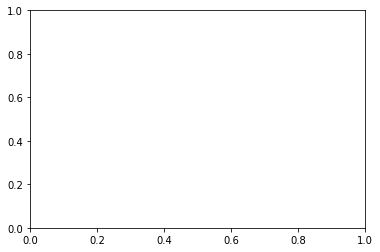

In [31]:
df.plot('product_mode_dow_ordered',by='in_cart',kind='kde')

In [47]:
ord_prod_train_df.groupby('product_id').reordered.sum().value_counts()

0       5999
1       1920
2        973
3        706
4        451
5        353
6        297
7        221
8        201
9        167
10       136
11       114
12        97
13        86
14        77
15        76
16        69
17        46
18        42
19        40
21        39
20        37
22        35
23        32
25        30
24        23
29        22
33        21
30        20
28        20
        ... 
274        1
119        1
132        1
100        1
1171       1
133        1
467        1
91         1
107        1
123        1
147        1
155        1
170        1
138        1
140        1
156        1
82         1
74         1
164        1
196        1
244        1
61         1
77         1
93         1
125        1
657        1
649        1
163        1
153        1
259        1
Name: reordered, Length: 157, dtype: int64

In [26]:
test = pd.read_csv('order_products__prior.csv')

In [31]:
test2 = pd.read_csv('orders.csv')

In [40]:
test3 = test.merge(test2,on='order_id')

In [39]:
test2.head()

order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0   2539329        1    prior             1          2                  8   
1   2398795        1    prior             2          3                  7   
2    473747        1    prior             3          3                 12   
3   2254736        1    prior             4          4                  7   
4    431534        1    prior             5          4                 15   

   days_since_prior_order  
0                     NaN  
1                    15.0  
2                    21.0  
3                    29.0  
4                    28.0

In [43]:
test3.product_id.nunique()

49677

In [44]:
test3.groupby('product_id',as_index=False).reordered.sum().value_counts()

0        4372
1        2928
2        2331
3        1857
4        1593
5        1331
6        1181
7        1048
8         918
9         817
10        753
11        667
12        661
13        630
14        609
16        509
15        503
17        460
19        447
18        442
20        383
22        372
21        368
23        355
24        347
25        318
26        307
28        303
27        290
29        272
         ... 
1837        1
23430       1
4911        1
2828        1
1814        1
4239        1
1878        1
3863        1
4335        1
7231        1
1084        1
8521        1
2380        1
5150        1
12651       1
1052        1
3799        1
13067       1
4527        1
2508        1
9176        1
4559        1
37343       1
4591        1
2572        1
3767        1
4655        1
2700        1
2732        1
4347        1
Name: reordered, Length: 3134, dtype: int64

In [18]:
pd.to_pickle(df,'mini_feature_df')